In [1]:
cd ..

/home/max/Documents/mgr


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from sklearn.decomposition import PCA
from tqdm import tqdm

from src.simplefact import *
from src.simplefact import Reasoner as FACT
from src.syntax import *
from src.generate import *
from src.reasoneur import *
from src.utils import *
from src.vis import *

seed = 2022

In [3]:
onto = load_owl('local/out/dataset/pizza.owl')
onto.use_annotations_as_names()
onto.use_prefix('pizza:')
fact = FACT(n_concepts=onto.n_concepts, n_roles=onto.n_roles, timeout=10_000)
for axiom in onto.tbox:
    fact.add_axiom(axiom)
    
C = onto.concept_by_name
R = onto.role_by_name
onto

Unsupported class expression ('SubClassOf', 'pizza:American', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:America'))
Unsupported class expression ('SubClassOf', 'pizza:AmericanHot', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:America'))
Unsupported class expression ('EquivalentClasses', 'pizza:Country', ('ObjectIntersectionOf', 'pizza:DomainConcept', ('ObjectOneOf', 'pizza:America', 'pizza:England', 'pizza:France', 'pizza:Germany', 'pizza:Italy')))
Unsupported class expression ('EquivalentClasses', 'pizza:InterestingPizza', ('ObjectIntersectionOf', 'pizza:Pizza', ('ObjectMinCardinality', '3', 'pizza:hasTopping')))
Unsupported class expression ('SubClassOf', 'pizza:MozzarellaTopping', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:Italy'))
Unsupported class expression ('SubClassOf', 'pizza:Napoletana', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:Italy'))
Unsupported class expression ('EquivalentClasses', 'pizza:RealItalianPizza', ('ObjectIntersection

<Onto 99 concepts, 3 roles, 280 axioms>

In [4]:
queries, answers, qset = [], [], set()
concepts = list(range(onto.n_concepts)) + [TOP, BOT]

for c in concepts:
    for d in concepts:
        append_unique((SUB, c, d), queries, qset)

for query in tqdm(queries):
    answers.append(float(fact.check_axiom(query)))

rng = np.random.default_rng(seed)
queries, answers = jointshuffle(rng, queries, answers)

print(len(answers))
print(np.mean(answers))

100%|██████████| 10201/10201 [00:00<00:00, 271433.71it/s]

10201
0.08508969708852074


In [5]:
Reasoner = ContextFreeReasoner
Encoder = NNExprEncoder
Optimizer = T.optim.AdamW
expr_size = 10

hidden_size = 16
epoch_count = 30 + 1
batch_size = 32
lr_reasoner = 0.0020
lr_encoder = lr_reasoner

X_te = [core(x) for x in queries]
y_te = answers
idx_te = [0]*len(X_te)

test_history = []
test_history_by_onto = []
rng = np.random.default_rng(seed)
T.manual_seed(seed)
reasoner = Reasoner(expr_size=expr_size, hidden_size=hidden_size)
#reasoner.load_state_dict(T.load('local/out/exp/20220529T021116/reasoner.pt'))
#freeze(reasoner)
reasoner_optim = Optimizer(reasoner.parameters(), lr=lr_reasoner)
encoder = Encoder.from_onto(onto, expr_size=expr_size)
encoder_optim = Optimizer(encoder.parameters(), lr=lr_encoder)
print(paramcount(reasoner))
print(paramcount(encoder))

test(test_data=(idx_te, X_te, y_te), test_onto=[onto],
     reasoner=reasoner, reasoner_name='pizza_reasoner',
     encoders=[encoder], optimizers=[encoder_optim], reasoner_optim=reasoner_optim,
     test_hist=test_history, test_hist_by_onto=test_history_by_onto,
     epoch_count=epoch_count, batch_size=batch_size, freeze_reasoner=False)

3283
1330
test epoch 01/31 | batch 319/319 | test loss 0.7311 | acc 0.0851 | f1 0.1568 | prec 0.0851 | recall 1.0000 | roc auc 0.4494 | elapsed 1.76s
test epoch 02/31 | batch 319/319 | test loss 0.1301 | acc 0.9612 | f1 0.7356 | prec 0.8746 | recall 0.6348 | roc auc 0.9207 | elapsed 2.86s
test epoch 03/31 | batch 319/319 | test loss 0.1204 | acc 0.9614 | f1 0.7352 | prec 0.8823 | recall 0.6302 | roc auc 0.9382 | elapsed 2.90s
test epoch 04/31 | batch 319/319 | test loss 0.1177 | acc 0.9599 | f1 0.7197 | prec 0.8883 | recall 0.6048 | roc auc 0.9433 | elapsed 2.86s
test epoch 05/31 | batch 319/319 | test loss 0.1119 | acc 0.9625 | f1 0.7389 | prec 0.9048 | recall 0.6244 | roc auc 0.9476 | elapsed 2.87s
test epoch 06/31 | batch 319/319 | test loss 0.1016 | acc 0.9671 | f1 0.7673 | prec 0.9618 | recall 0.6382 | roc auc 0.9571 | elapsed 2.87s
test epoch 07/31 | batch 319/319 | test loss 0.0833 | acc 0.9772 | f1 0.8539 | prec 0.9367 | recall 0.7846 | roc auc 0.9707 | elapsed 2.84s
test epoch

In [6]:
with T.no_grad():
    reasoner.eval()
    _, _, Y_te = eval_batch(reasoner, [encoder], X_te, y_te, idx_te)

In [7]:
test_history_by_onto = pd.DataFrame(test_history_by_onto)
test_history = pd.DataFrame(test_history)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te))

,mean,std,micro
acc,1.0,NaN,1.0
prec,1.0,NaN,1.0
recall,1.0,NaN,1.0
f1,1.0,NaN,1.0
auc_roc,1.0,NaN,1.0
ap,1.0,NaN,1.0


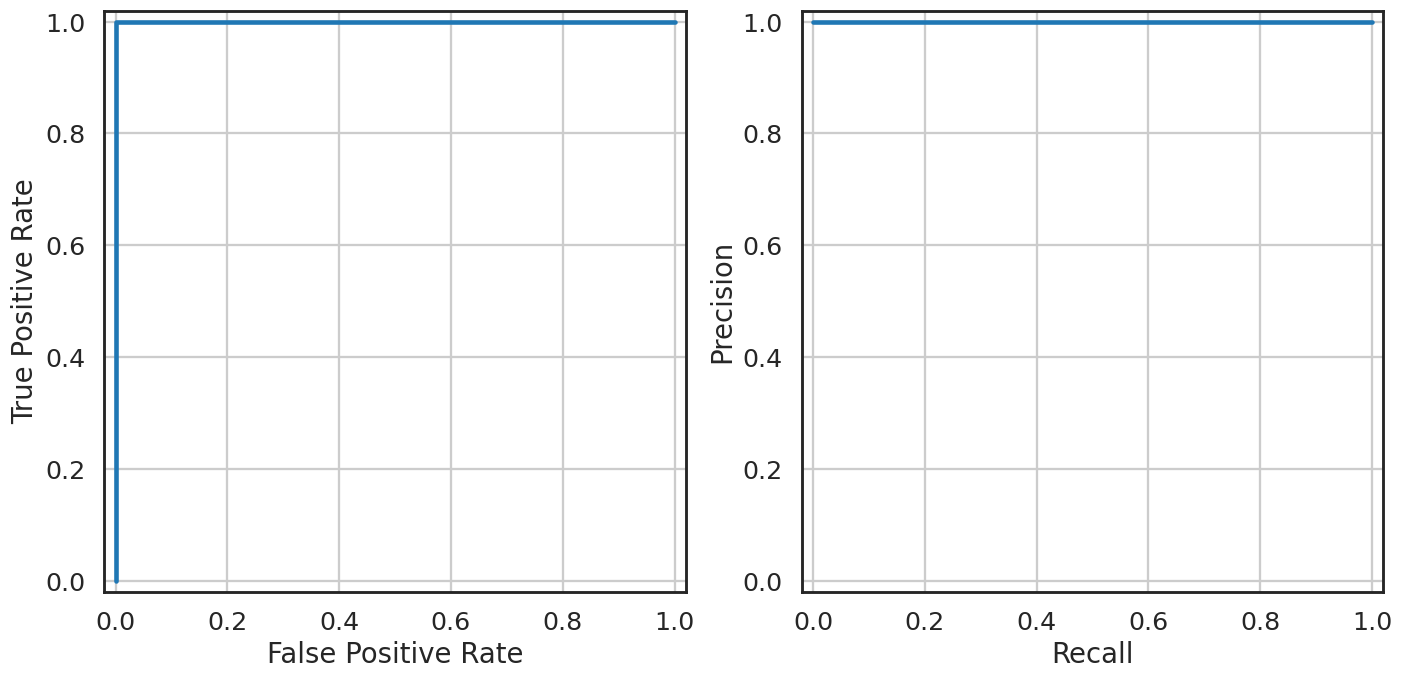

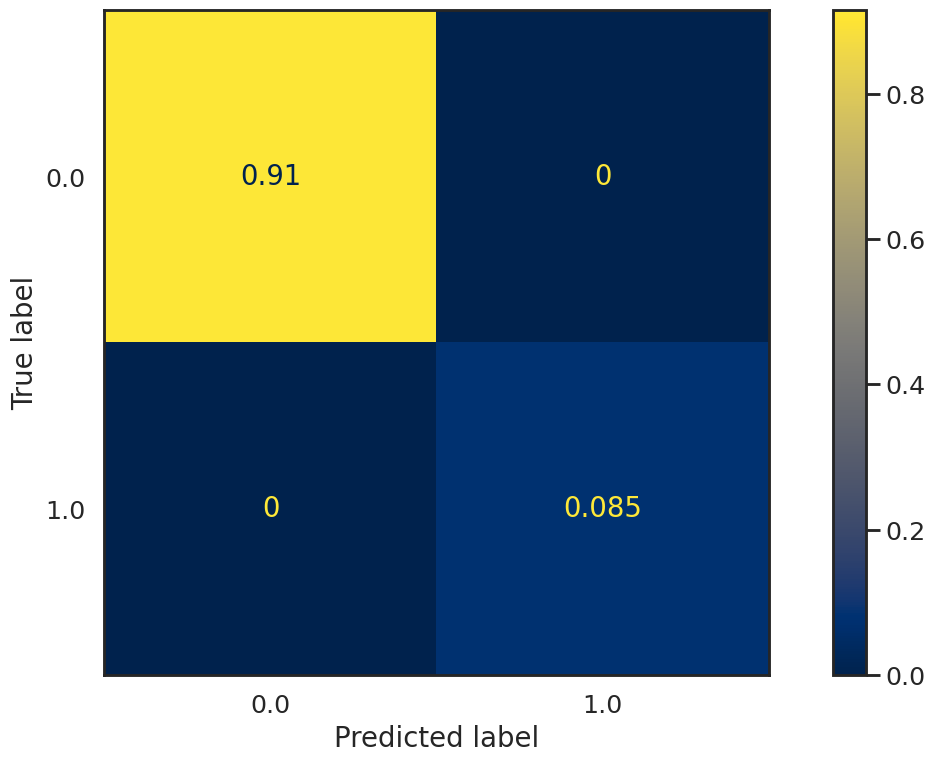

In [8]:
#plot_test_history(test_history, test_history_by_onto)
report([onto], y_te, Y_te, idx_te)

In [9]:
pizzann = ReasonerPackage(reasoner, encoder)

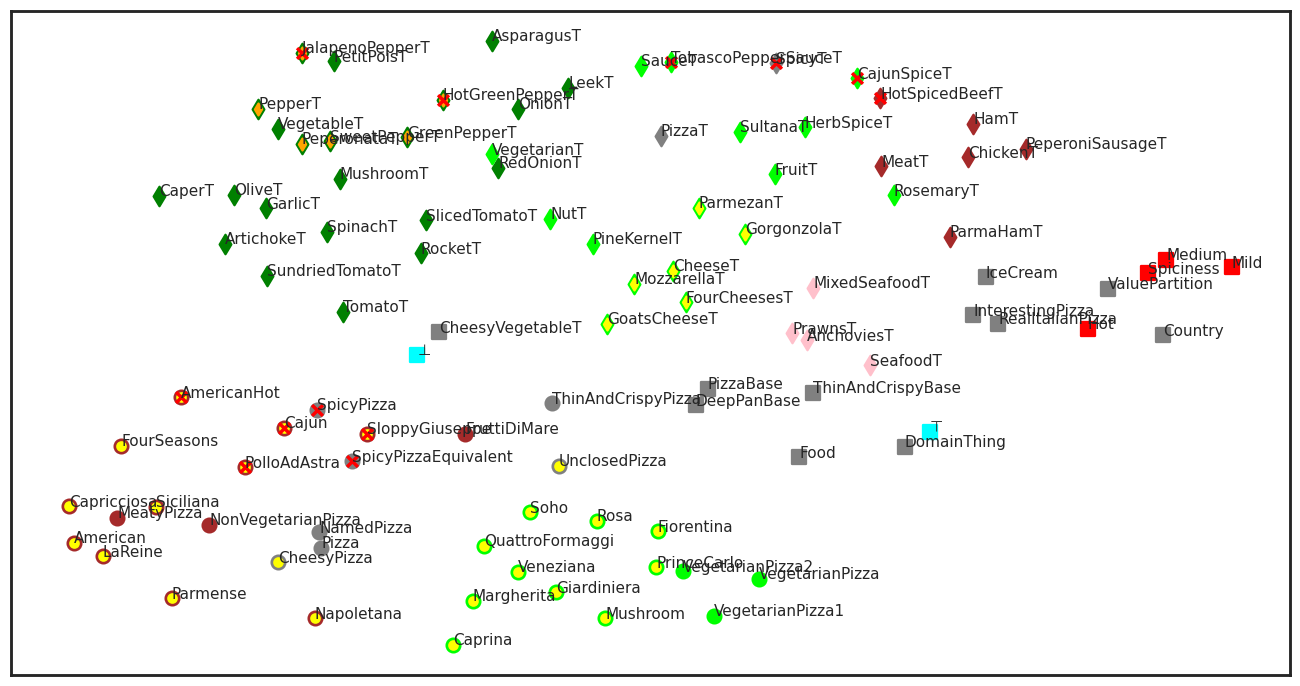

In [17]:
from umap import UMAP
pca = UMAP(n_components=2, n_neighbors=50, min_dist=0.1, random_state=seed)

exclude = {}
manual_exprs = [C[x] for x in C if x not in exclude]
manual_exprs += [TOP, BOT]

exprs, texts, colors, markers = [], [], [], []
for expr in manual_exprs:
    exprs.append(pizzann.encode(expr))
    texts.append(to_pretty(expr, onto=onto))
    
    if fact.check_eqv(expr, BOT):
        m = 's'
    elif fact.check_sub(expr, C.Pizza):
        m = 'o'
    elif fact.check_sub(expr, C.PizzaTopping):
        m = 'd'
    else:
        m = 's'
    
    c = 'gray'
    if isinstance(expr, tuple) or expr in {TOP, BOT}:
        c = 'cyan'
        m = 's'
    elif not fact.check_sub(expr, BOT):
        if fact.check_sub(expr, C.VegetarianPizza): c = 'lime'
        if fact.check_sub(expr, C.NonVegetarianPizza): c = 'brown'

        if fact.check_sub(expr, C.VegetarianTopping): c = 'lime'
        if fact.check_sub(expr, C.VegetableTopping): c = 'green'
        if fact.check_sub(expr, C.MeatTopping): c = 'brown'
        if fact.check_sub(expr, C.SeafoodTopping): c = 'pink'
        if fact.check_sub(expr, C.Spiciness): c = 'red'
    
    colors.append(c)
    markers.append(m)

xs, ys = pca.fit_transform(np.array(exprs)).T
for x, y, text, color, marker, expr in zip(xs, ys, texts, colors, markers, manual_exprs):
    plt.scatter(x, y, marker=marker, color=color)
    if not (isinstance(expr, tuple) or fact.check_sub(expr, BOT)):
        if fact.check_sub(expr, (OR, C.CheeseTopping, C.CheesyPizza)):
            plt.scatter(x, y, marker=marker, color='yellow', s=30)
        if fact.check_sub(expr, C.PepperTopping):
            plt.scatter(x, y, marker=marker, color='orange', s=30)
        if fact.check_sub(expr, (OR, C.SpicyTopping, C.SpicyPizza)):
            plt.scatter(x, y, marker='x', color='red', s=50)
    plt.text(x, y, text.replace('Topping', 'T'), fontsize=10)
    
plt.xticks([]); plt.yticks([])
plt.show()

In [12]:
def is_disjoint_axiom(axiom):
    _, c, d = axiom
    return isinstance(c, tuple) and c[0] == AND and d is False

df = []
for x, y, Y_proba in zip(X_te, y_te, Y_te):
    y, Y = bool(y), bool(Y_proba > 0.5)
    ok = y == Y 
    df.append(dict(
        y=y, Y=Y, correct=y == Y, proba=round(Y_proba, 6),
        depth=expr_depth(x),
        lbot=fact.check_eqv(x[1], False),
        rtop=fact.check_eqv(x[2], True),
        disj=is_disjoint_axiom(x),
        trivial=x[1] == x[2],
        axiom=to_pretty(x, onto=onto),
    ))
            
df = pd.DataFrame(df)
print(df.correct.mean())
df

1.0


,y,Y,correct,proba,depth,lbot,rtop,disj,trivial,axiom
0,False,False,True,0.000339,1,False,False,False,False,NutTopping ⊑ NamedPizza
1,False,False,True,0.000000,1,False,False,False,False,NamedPizza ⊑ AnchoviesTopping
2,False,False,True,0.000000,1,False,False,False,False,Medium ⊑ Giardiniera
3,False,False,True,0.000000,1,False,False,False,False,VegetarianPizza1 ⊑ FourCheesesTopping
4,False,False,True,0.000000,1,False,False,False,False,SpicyTopping ⊑ ParmezanTopping
...,...,...,...,...,...,...,...,...,...,...
10196,False,False,True,0.000000,1,False,False,False,False,HotGreenPepperTopping ⊑ FourSeasons
10197,False,False,True,0.000000,1,False,False,False,False,DeepPanBase ⊑ SundriedTomatoTopping
10198,True,True,True,0.997548,1,False,False,False,False,HotGreenPepperTopping ⊑ PepperTopping
10199,False,False,True,0.000000,1,False,False,False,False,ArtichokeTopping ⊑ FruitTopping


In [13]:
df.groupby('correct').mean()

,y,Y,proba,depth,lbot,rtop,disj,trivial
correct,,,,,,,,
True,0.08509,0.08509,0.085329,1.0,0.009901,0.009901,0.0,0.009901


In [14]:
df.groupby('y').count()

,Y,correct,proba,depth,lbot,rtop,disj,trivial,axiom
y,,,,,,,,,
False,9333,9333,9333,9333,9333,9333,9333,9333,9333
True,868,868,868,868,868,868,868,868,868


In [15]:
xs = sorted(list(range(onto.n_concepts)), key=lambda i: onto.concepts[i])
ticks = [to_pretty(x, onto=onto).replace('Topping', 'T') for x in xs]
n = len(xs)
sub_fact = np.zeros((n, n))
sub_nn = np.zeros((n, n))
for i, c in enumerate(xs):
    for j, d in enumerate(xs):
        sub_fact[i][j] = fact.check_sub(c, d)
        sub_nn[i][j] = pizzann.check_sub(c, d)

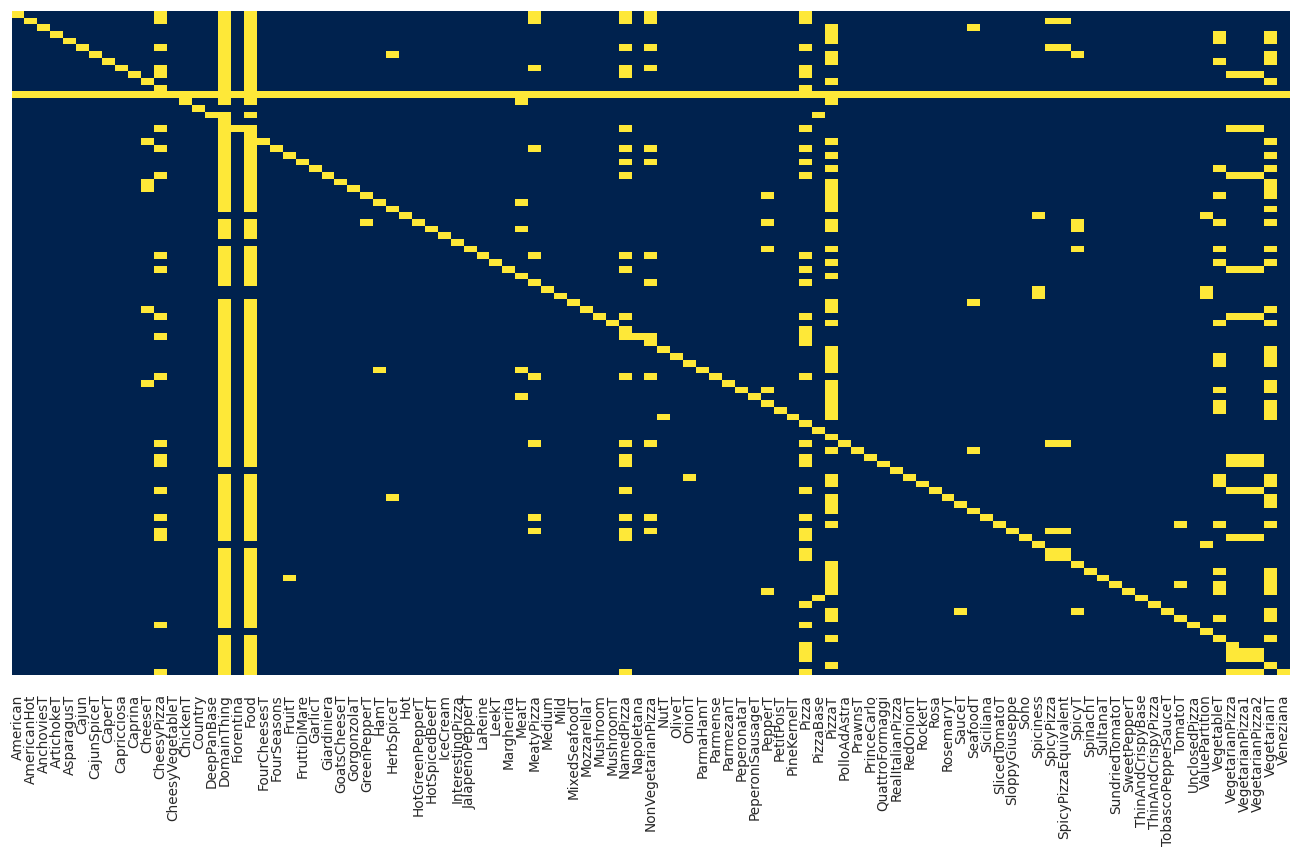

In [16]:
#fig, ax1 = plt.subplots(figsize=(30, 25))
sns.heatmap(sub_fact, xticklabels=ticks, yticklabels=ticks, cbar=False, cmap='cividis')
#sns.heatmap(sub_nn > 0.5, xticklabels=ticks, square=True, cbar=False, cmap='cividis', ax=ax2)
#sns.heatmap(sub_nn, xticklabels=ticks, square=True, cbar=False, cmap='cividis', ax=ax3)
#plt.title('$A_i \sqsubseteq A_j$')
#ax2.set_title('Binarized predictions')
#ax3.set_title('Predictions')

#for ax in (ax1, ax2, ax3):
#    ax.set_yticklabels([])
#    ax.set_xticklabels([])

plt.yticks([])
plt.xticks(fontsize=8.9)
plt.grid(True)
plt.show()
#sns.scatter(x='depth', y=)
#df.groupby('depth').mean()
#sns.histplot(x='depth', hue='correct', stat='percent', data=df)

In [18]:
test_history.groupby('test_epoch').max().elapsed.sum()

67.8118405342102